# 超参优化

## GridSearch用法

In [1]:
from sklearn.model_selection import GridSearchCV

<font color='blue' size=3>GridSearchCV参数</font>

|参数|默认值|解释|
|:-------:|:---|:--------|
|estimator|无|模型估计器，使用scikit-learn的接口。|
|param_grid|无|需要遍历的参数和取值。|
|scoring|None|模型评价标准，默认None,这时需要使用score函数,或者如scoring='roc_auc'，根据所选模型不同，评价准则不同。|
|fit_params|None||
|n_jobs|None|并行数，int,-1:跟CPU核数一致。|
|iid|'warn'|默认为True，各个样本fold概率分布一致。|
|refit|True|再搜索参数结束后，用最佳参数结果再次fit一遍全部数据集。|
|cv|None|默认为None，就是3折交叉验证，可以指定fold数量。|
|verbose|0|日志长度，0：不输出训练过程；1：偶尔输出；>1：每个子模型都输出。|
|pre_dispatch|'2*n_jobs'|预派遣任务数，指定总分发的并行任务数。|
|err_score|'raise-deprecating'|默认值：在拟合过程中产生误差，误差分数会提高。|
|return_train_score|'warn'|默认为True，返回的cv_results_属性包括训练分数。|
[scoring取值](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
)

<font color='blue' size=3>GridSearchCV例子</font>

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
#用sklearn自带数据集
dt = datasets.load_breast_cancer()
trainSet = dt.data
Label = dt.target
#划分训练集和测试集
X_train,X_test,y_train,y_test= train_test_split(trainSet,Label,test_size=0.2,random_state=1234)

**先直接用默认超参数的LightGBM建模**

In [26]:
#用lightgbm模型
from lightgbm.sklearn import LGBMClassifier
#调用实例
lgbm = LGBMClassifier(reg_alpha=1)

In [27]:
#训练
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=1, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [28]:
#预测结果
lgbm_preY_prob = lgbm.predict_proba(X_test)[:,1]
lgbm_preY = lgbm.predict(X_test)

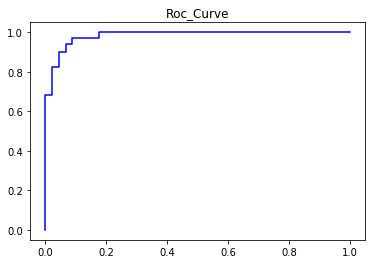

auc:0.983


In [29]:
#ROC和AUC评价
import matplotlib.pyplot as plt
from sklearn import metrics
fpr, tpr, thres = metrics.roc_curve(y_test, lgbm_preY_prob)
auc = metrics.roc_auc_score(y_test, lgbm_preY_prob)
plt.plot(fpr, tpr, "b-")
plt.title("Roc_Curve")
plt.show()
print("auc:%.3f"%auc)

**用GridSearch寻找LightGBM模型超参**

In [30]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt

In [31]:
#准备模型
lgbm_clf = LGBMClassifier(reg_alpha=1)
#准备参数
num_leaves = range(10, 35, 1)
max_depth = range(3, 7, 1)
learning_rate = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
n_estimators = range(50, 160, 10)
params_grid = dict(num_leaves=num_leaves, max_depth=max_depth, 
                   learning_rate=learning_rate, n_estimators=n_estimators)

In [32]:
#实例化gridsearchCV模型，并训练
grsearch = GridSearchCV(estimator = lgbm_clf,
                        param_grid = params_grid,
                        scoring = 'roc_auc',
                        cv = 5,
                        n_jobs = -1,
                        verbose = 2)
grsearch.fit(X_train, y_train)

Fitting 5 folds for each of 6600 candidates, totalling 33000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 2388 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 3668 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 5128 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 6908 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9016 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 11444 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 14200 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 17276 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 20680 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 24404 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 28456 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 32828 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 33000 out

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=1, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'num_leaves': range(10, 35), 'max_depth': range(3, 7), 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5], 'n_estimators': range(50, 160, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [33]:
#导出结果
best_lgbm_clf = grsearch.best_estimator_
best_lgbm_params = grsearch.best_params_
best_lgbm_score = grsearch.best_score_
print(best_lgbm_score)
print(best_lgbm_params)
print(best_lgbm_clf)

0.9955150788501915
{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50, 'num_leaves': 10}
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.5, max_depth=3, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=1, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)


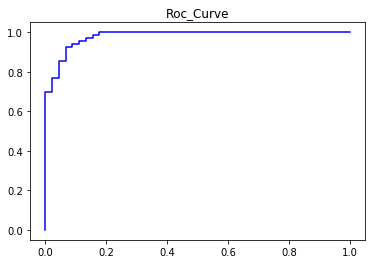

auc:0.980


In [34]:
#预测测试集结果
lgbm_preY_prob = best_lgbm_clf.predict_proba(X_test)[:,1]
lgbm_preY = best_lgbm_clf.predict(X_test)
#ROC和AUC评价
fpr, tpr, thres = metrics.roc_curve(y_test, lgbm_preY_prob)
auc = metrics.roc_auc_score(y_test, lgbm_preY_prob)
plt.plot(fpr, tpr, "b-")
plt.title("Roc_Curve")
plt.show()
print("auc:%.3f"%auc)

## RandomizedSearch用法

In [35]:
from sklearn.model_selection import RandomizedSearchCV

<font color='blue' size=3>RandomizedSearchCV参数</font>

|参数|默认值|解释|
|:-------:|:---|:--------|
|estimator|无|模型估计器，使用scikit-learn的接口。|
|param_distributions|无|需要遍历的参数和取值。|
|n_iter|10|抽样次数。|
|scoring|None|模型评价标准，默认None,这时需要使用score函数,或者如scoring='roc_auc'，根据所选模型不同，评价准则不同。|
|fit_params|None||
|n_jobs|None|并行数，int,-1:跟CPU核数一致。|
|iid|'warn'|默认为True，各个样本fold概率分布一致。|
|refit|True|再搜索参数结束后，用最佳参数结果再次fit一遍全部数据集。|
|cv|None|默认为None，就是3折交叉验证，可以指定fold数量。|
|verbose|0|日志长度，0：不输出训练过程；1：偶尔输出；>1：每个子模型都输出。|
|pre_dispatch|'2*n_jobs'|预派遣任务数，指定总分发的并行任务数。|
|random_state|None|随机种子，int，随即状态是随机数生成器所使用的种子。|
|err_score|'raise-deprecating'|默认值：在拟合过程中产生误差，误差分数会提高。|
|return_train_score|'warn'|默认为True，返回的cv_results_属性包括训练分数。|
[scoring取值](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
)

<font color='blue' size=3>RandomizedSearchCV例子</font>

**用RandomizedSearch寻找LightGBM模型超参**

In [41]:
#准备模型
lgbm_clf = LGBMClassifier(reg_alpha=1)
#准备参数
num_leaves = range(10, 35, 1)
max_depth = range(3, 7, 1)
learning_rate = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
n_estimators = range(50, 160, 10)
params_random = dict(num_leaves=num_leaves, max_depth=max_depth, 
                   learning_rate=learning_rate, n_estimators=n_estimators)

In [42]:
#实例化randomizedsearchCV模型，并训练
rdsearch = RandomizedSearchCV(estimator = lgbm_clf,
                        param_distributions = params_random,
                        n_iter = 100,
                        scoring = 'roc_auc',
                        cv = 5,
                        n_jobs = -1,
                        verbose = 2)
rdsearch.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 485 out of 500 | elapsed:    7.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.7s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=1, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'num_leaves': range(10, 35), 'max_depth': range(3, 7), 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5], 'n_estimators': range(50, 160, 10)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [43]:
#导出结果
best_lgbm_clf = rdsearch.best_estimator_
best_lgbm_params = rdsearch.best_params_
best_lgbm_score = rdsearch.best_score_
print(best_lgbm_score)
print(best_lgbm_params)
print(best_lgbm_clf)

0.9955150788501915
{'num_leaves': 12, 'n_estimators': 130, 'max_depth': 3, 'learning_rate': 0.5}
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.5, max_depth=3, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=130,
        n_jobs=-1, num_leaves=12, objective=None, random_state=None,
        reg_alpha=1, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)


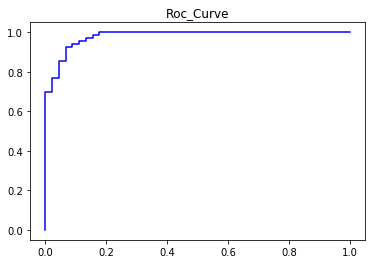

auc:0.980


In [44]:
#预测测试集结果
lgbm_preY_prob = best_lgbm_clf.predict_proba(X_test)[:,1]
lgbm_preY = best_lgbm_clf.predict(X_test)
#ROC和AUC评价
fpr, tpr, thres = metrics.roc_curve(y_test, lgbm_preY_prob)
auc = metrics.roc_auc_score(y_test, lgbm_preY_prob)
plt.plot(fpr, tpr, "b-")
plt.title("Roc_Curve")
plt.show()
print("auc:%.3f"%auc)

# BayesianOptimization用法

In [45]:
from bayes_opt import BayesianOptimization

<font color='blue' size=3>BayesianOptimization参数</font>

|参数|默认值|解释|
|:-------:|:---|:--------|
|f|无|自己定义的函数。|
|pbounds|无|定义函数的参数。|
|random_state|None|随机种子，int，随即状态是随机数生成器所使用的种子。|
|verbose|0|日志长度，0：不输出训练过程；1：偶尔输出；>1：每个子模型都输出。|

<font color='blue' size=3>BayesianOptimization例子</font>

**用Bayes_Opt寻找LightGBM模型超参**

In [47]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [63]:
def lgbm_cv(num_leaves, max_depth, learning_rate, n_estimators):
    params = dict(num_leaves=int(num_leaves), 
                  max_depth=int(max_depth),
                  learning_rate=round(learning_rate,2),
                  n_estimators=int(n_estimators))
    lgbm_clf = LGBMClassifier(**params)
    cv_scores = cross_val_score(lgbm_clf, X_train, y_train, scoring='roc_auc', cv=5)
    return cv_scores.mean()

In [65]:
lgbm_bayes_opt = BayesianOptimization(lgbm_cv,
                                      {'num_leaves':(10,35),
                                       'max_depth':(3,7),
                                       'learning_rate':(0.01,0.5),
                                       'n_estimators':(30,150)
                                      })
lgbm_bayes_opt.maximize()

|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.9938   |  0.05303  |  5.86     |  91.33    |  24.1     |
|  2        |  0.9959   |  0.2451   |  4.669    |  57.59    |  20.04    |
|  3        |  0.9947   |  0.03573  |  6.124    |  146.8    |  20.77    |
|  4        |  0.9949   |  0.2918   |  4.454    |  34.57    |  30.17    |
|  5        |  0.9954   |  0.3994   |  3.977    |  145.4    |  26.72    |
|  6        |  0.9946   |  0.431    |  6.674    |  30.0     |  10.08    |
|  7        |  0.9953   |  0.239    |  3.486    |  149.8    |  10.0     |
|  8        |  0.9961   |  0.3779   |  6.651    |  150.0    |  34.96    |
|  9        |  0.9956   |  0.3382   |  6.216    |  149.9    |  34.95    |
|  10       |  0.9956   |  0.2258   |  3.156    |  149.9    |  34.97    |
|  11       |  0.9955   |  0.173    |  6.861    |  149.9    |  10.23    |
|  12       |  0.9947   |  0.3014   | 

In [67]:
print(lgbm_bayes_opt.max)

{'target': 0.9967712784943489, 'params': {'learning_rate': 0.43763221277141123, 'max_depth': 6.552217306264733, 'n_estimators': 149.38656418295477, 'num_leaves': 10.097408378859809}}


In [71]:
#得到最优参数后重新训练
params = dict(num_leaves=int(lgbm_bayes_opt.max['params']['num_leaves']), 
                  max_depth=int(lgbm_bayes_opt.max['params']['max_depth']),
                  learning_rate=round(lgbm_bayes_opt.max['params']['learning_rate'],2),
                  n_estimators=int(lgbm_bayes_opt.max['params']['n_estimators']))
lgbm_clf_bayes = LGBMClassifier(**params,reg_lambda=1)
lgbm_clf_bayes.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.44, max_depth=6, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=149,
        n_jobs=-1, num_leaves=10, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

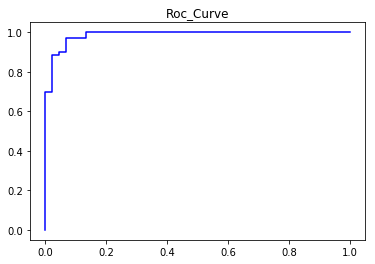

auc:0.986


In [72]:
#预测测试集结果
lgbm_preY_prob = lgbm_clf_bayes.predict_proba(X_test)[:,1]
lgbm_preY = lgbm_clf_bayes.predict(X_test)
#ROC和AUC评价
fpr, tpr, thres = metrics.roc_curve(y_test, lgbm_preY_prob)
auc = metrics.roc_auc_score(y_test, lgbm_preY_prob)
plt.plot(fpr, tpr, "b-")
plt.title("Roc_Curve")
plt.show()
print("auc:%.3f"%auc)

**另一种DEMO**

In [ ]:
import lightgbm as lgb
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000,n_features=20,n_classes=2,random_state=2)
data = lgb.Dataset(X,y)

def lgb_cv(feature_fraction,bagging_fraction,min_data_in_leaf,max_depth,min_split_gain,num_leaves,lambda_l1,lambda_l2,num_iterations=1000):
        params = {'objective':'binary','num_iterations': num_iterations, 'early_stopping_round':50, 'metric':'l1'}
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params["min_data_in_leaf"] = int(round(min_data_in_leaf))
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain      
        params["num_leaves"] = int(round(num_leaves))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        
        cv_result = lgb.cv(params, data, nfold=5, seed=2, stratified=True, verbose_eval =50)
        return -(min(cv_result['l1-mean']))

lgb_bo = BayesianOptimization(
        lgb_cv,
        {'feature_fraction': (0.5, 1),
        'bagging_fraction': (0.5, 1),
        'min_data_in_leaf': (1,100),
        'max_depth': (3, 15),
         'min_split_gain': (0, 5),
         'num_leaves': (16, 128),
         'lambda_l1': (0, 100),
         'lambda_l2': (0, 100)}
    )        

lgb_bo.maximize(init_points=21,n_iter=90) #init_points表示初始点，n_iter代表迭代次数（即采样数）
print (lgb_bo.max)